In [1]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from peft.tuners.lora import LoraModel, LoraConfig

# 1. Re-create the base model and tokenizer
tokenizer  = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
base_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

# 2. Re-apply the exact same LoRA configuration
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=64,
    lora_dropout=0.15,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin", "lin1", "lin2"],
)
encoder     = base_model.distilbert
lora_encoder= LoraModel(encoder, lora_config, adapter_name="default")
base_model.distilbert = lora_encoder

# 3. Load the saved weights
state = torch.load("best_model.pt", map_location="cpu")
base_model.load_state_dict(state)

# 4. Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# 5. Ensure only adapter dropouts are in train mode
base_model.eval()  # first, disable all dropout
for name, module in base_model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        # keep only LoRA-dropout layers active
        if "lora_dropout" in name:
            module.train()
        else:
            module.eval()

# (Optional) debug print to verify
# for name, module in base_model.named_modules():
#     if isinstance(module, torch.nn.Dropout):
#         print(f"{name:60s} training={module.training}")

# 6. Define mc-dropout inference
def mc_dropout_predict(texts, T=20):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    logits = []
    with torch.no_grad():
        for _ in range(T):
            logits.append(base_model(**inputs).logits.unsqueeze(0))
    logits = torch.cat(logits, dim=0)
    probs  = torch.softmax(logits, dim=-1)
    return probs.mean(dim=0), probs.var(dim=0)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 12. Example usage
texts = [
    "This movie was fantastic!",
    "The plot was hard to follow.",
    "I've seen better films",
    "The quarterly earnings exceeded expectations.",
    "florgle wumpus theory extrapolates"
]
mean, var = mc_dropout_predict(texts, T=100)

for t, m, v in zip(texts, mean, var):
    print(f"Input: {t}")
    print(f"  Mean probs: neg={m[0]:.3f}, pos={m[1]:.3f}")
    print(f"  Var probs:  neg={v[0]:.5f}, pos={v[1]:.5f}")

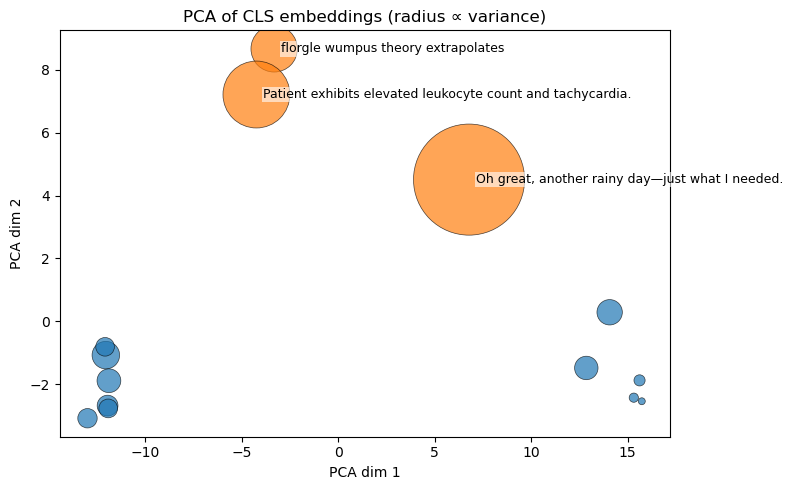

In [34]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch

# Function to get MC-dropout CLS embeddings and their variance
def mc_dropout_embedding(texts, T=20):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
    reps = []
    with torch.no_grad():
        for _ in range(T):
            outputs = base_model.distilbert(**inputs)
            cls_rep = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            reps.append(cls_rep)
    reps = np.vstack(reps)  # shape [T * batch, hidden_size]
    mean_reps = reps.reshape(T, -1, reps.shape[-1]).mean(axis=0)  # [batch, hidden_size]
    var_reps = reps.reshape(T, -1, reps.shape[-1]).var(axis=0).mean(axis=1)  # [batch]
    return mean_reps, var_reps

# Define in-domain and OOD samples
in_dist_texts = [
    "This movie was fantastic!",
    "An utter masterpiece—I loved every moment.",
    "The plot was predictable and boring.",
    'that loves its characters and communicates something rather beautiful about human nature ',
    'remains utterly satisfied to remain the same throughout ',
    'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
    "that 's far too tragic to merit such superficial treatment ",
    'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
    "a depressed fifteen-year-old 's suicidal poetry ",
    'goes to absurd lengths ',
    'saw how bad this movie was ',
    ]
ood_texts = [
    "florgle wumpus theory extrapolates",
    "Patient exhibits elevated leukocyte count and tachycardia.",
    "Oh great, another rainy day—just what I needed."
]
all_texts = in_dist_texts + ood_texts

# Compute embeddings and variances
mean_embeddings, embedding_vars = mc_dropout_embedding(all_texts, T=20)

# t-SNE projection
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(mean_embeddings)

# True min–max normalize variances, then map to radii
in_domain_count = len(in_dist_texts)

# 1) Compute radii with exaggerated max
v_min, v_max = embedding_vars.min(), embedding_vars.max()
min_r, max_r = 5, 80
if v_max > v_min:
    norm = (embedding_vars - v_min) / (v_max - v_min)
    radii = norm * (max_r - min_r) + min_r
else:
    radii = np.full_like(embedding_vars, min_r)

# 2) Plot
plt.figure(figsize=(8,5))
plt.scatter(
    coords[:in_domain_count,0], coords[:in_domain_count,1],
    s=radii[:in_domain_count]**2, c='C0', alpha=0.7,
    edgecolors='k', linewidth=0.5, label=None
)
plt.scatter(
    coords[in_domain_count:,0], coords[in_domain_count:,1],
    s=radii[in_domain_count:]**2, c='C1', alpha=0.7,
    edgecolors='k', linewidth=0.5, label=None
)

# 3) Annotate top-k
for idx in topk_idx:
    x, y = coords[idx]
    plt.annotate(
        all_texts[idx], xy=(x,y), xytext=(5,0), textcoords='offset points',
        ha='left', va='center', fontsize=9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

# 4) Legend proxies
handles = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor='C0',
           markeredgecolor='k', markersize=10, label='In-Distribution'),
    Line2D([0],[0], marker='o', color='w', markerfacecolor='C1',
           markeredgecolor='k', markersize=10, label='Out-of-Distribution')
]
#plt.legend(handles=handles, loc='upper right', title='Data Type')

plt.title(f"PCA of CLS embeddings (radius ∝ variance)") 
plt.xlabel("PCA dim 1") 
plt.ylabel("PCA dim 2") 
plt.tight_layout()
plt.show()

In [30]:
# 2. Run MC-dropout predictions
mean_ext, var_ext = mc_dropout_predict(all_texts, T=20)

# 3. Print results
for text, m, v in zip(all_texts, mean_ext, var_ext):
    print(f"Input: {text}")
    print(f"  Mean prob -> neg: {m[0]:.3f}, pos: {m[1]:.3f}")
    print(f"  Var prob -> neg: {v[0]:.5f}, pos: {v[1]:.5f}")
    print("-" * 60)

Input: This movie was fantastic!
  Mean prob -> neg: 0.021, pos: 0.979
  Var prob -> neg: 0.00000, pos: 0.00000
------------------------------------------------------------
Input: An utter masterpiece—I loved every moment.
  Mean prob -> neg: 0.018, pos: 0.982
  Var prob -> neg: 0.00000, pos: 0.00000
------------------------------------------------------------
Input: The plot was predictable and boring.
  Mean prob -> neg: 0.975, pos: 0.025
  Var prob -> neg: 0.00000, pos: 0.00000
------------------------------------------------------------
Input: that loves its characters and communicates something rather beautiful about human nature 
  Mean prob -> neg: 0.017, pos: 0.983
  Var prob -> neg: 0.00000, pos: 0.00000
------------------------------------------------------------
Input: remains utterly satisfied to remain the same throughout 
  Mean prob -> neg: 0.031, pos: 0.969
  Var prob -> neg: 0.00000, pos: 0.00000
------------------------------------------------------------
Input: on th